## Comparing fitted model to TNG50, TNG100, and TNG300

In [198]:
import os
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit

#from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck15  as cosmo# Planck 2018
from astropy.cosmology import z_at_value
from astropy.table import Table

from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap

############################
# Custom scripts
import get_ZdepSFRD as Z_SFRD
import paths
import init_values as In

In [199]:
data_dir    =  str(paths.data) +'/'
save_loc = str(paths.figures) + '/'
COMPASfilename = 'COMPAS_Output_wWeights.h5'

filenames = ['SFRMetallicityFromGasTNG50-1.hdf5', 'SFRMetallicityFromGasTNG100-1.hdf5', 'SFRMetallicityFromGasTNG300-1.hdf5'] 
            #'SFRMetallicityFromGasTNG100-2.hdf5'] #, 'SFRMetallicityFromGasTNG50-2.hdf5', 'SFRMetallicityFromGasTNG50-3.hdf5']
rates = ['Rate_info_TNG50.h5', 'Rate_info_TNG100.h5', 'Rate_info_TNG300.h5']#, 'Rate_info_TNG100-2.h5'] #, 'Rate_info_TNG50-2.h5', 'Rate_info_TNG50-3.h5']
fit_params = ['test_best_fit_parameters_TNG50.txt', 'test_best_fit_parameters_TNG100.txt', 'test_best_fit_parameters_TNG300.txt']
              #'test_best_fit_parameters_TNG100-2.txt'] #, 'test_best_fit_parameters_TNG50-2.txt', 'test_best_fit_parameters_TNG50-3.txt']
Rboxvals = [35, 75, 205, 75, 35, 35]
fit_colors = ['#044082', '#2b7fd9', '#73b1f5', '#168f9e', '#2fc3d6', '#5ed7e6']
labels = ['50-1', '100-1', '300-1']
data_colors = ['#c74d22', '#eb6a3d', '#fe875d', '#35801c', '#4fb52d', '#82e660']

In [190]:
filenames = ['SFRMetallicityFromGasTNG50-1.hdf5', 'SFRMetallicityFromGasTNG100-1.hdf5', 'SFRMetallicityFromGasTNG300-1.hdf5'] 
            #'SFRMetallicityFromGasTNG100-2.hdf5'] #, 'SFRMetallicityFromGasTNG50-2.hdf5', 'SFRMetallicityFromGasTNG50-3.hdf5']
rates = ['Rate_info_TNG50.h5', 'Rate_info_TNG100.h5', 'Rate_info_TNG300.h5']#, 'Rate_info_TNG100-2.h5'] #, 'Rate_info_TNG50-2.h5', 'Rate_info_TNG50-3.h5']
fit_params = ['test_best_fit_parameters_TNG50.txt', 'test_best_fit_parameters_TNG100.txt', 'test_best_fit_parameters_TNG300.txt','best_fit_parameters_TNG50_no_omega_z.txt', 'best_fit_parameters_TNG100_no_omega_z.txt', 'best_fit_parameters_TNG300_no_omega_z.txt']
              #'test_best_fit_parameters_TNG100-2.txt'] #, 'test_best_fit_parameters_TNG50-2.txt', 'test_best_fit_parameters_TNG50-3.txt']
Rboxvals = [35, 75, 205, 35, 75, 205]
fit_colors = ['#044082', '#2b7fd9', '#73b1f5', '#35801c', '#4fb52d', '#82e660']
labels = ['50-1', '100-1', '300-1' ,'50-1, no omega_z', '100-1, no omega_z', '300-1, no omega_z']
data_colors = ['#c74d22', '#eb6a3d', '#fe875d', '#c74d22', '#eb6a3d', '#fe875d'] 

In [200]:
#define chirp mass function
def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass   

In [201]:
fit_param_vals = []

for file in fit_params:
    try:
        mu0_best, muz_best, omega0_best, omegaz_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best = np.loadtxt(str(paths.data)+'/'+file,unpack=True, delimiter=',')
        fit_param_vals.append([mu0_best, muz_best, omega0_best, omegaz_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best])
    except ValueError:
        mu0_best, muz_best, omega0_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best = np.loadtxt(str(paths.data)+'/'+file,unpack=True, delimiter=',')
        fit_param_vals.append([mu0_best, muz_best, omega0_best, alpha0_best, sf_a_best, sf_b_best, sf_c_best, sf_d_best])

In [202]:
#values
In.init()
Zsun = 0.014 # Solar metallicity
obs_SFRD = []
min_logZ  = -12.0
max_logZ  = 0.0
step_logZ = 0.01
add_TNG = False, 
plot_dPdZcontours = True
neijssel_fit = True
FITkleur="crest"
dPdZ_text = ''
SFR_text = ''
tmin = 0.0
tmax = 13.7

## Comparing SFRD(z)

In [203]:
def powerlaw_fit_Chruslinska21(z_bounds= [0,1.0,1.8,4.0,7.0,8.8, 10.0], 
                                   kappa_list = [2.3822, 2.2105, -1.2278,-2.4769, -12.5280, 0],
                                   A_list = [0.0248, 0.028, 0.964, 7.2, 8.6*10**9, 0.00328]):
        """
        Powerlaw approximation from Chruslinska +2021 (Fig. 11 and tables 3 and B2)
        Default values are upper edge of Cosmic SFH – SB: B18/C17 == Thick brown line in fig. 11
        """
        redshifts, SFRD = [], []
        for i in range(len(z_bounds) -1):
            z    = np.linspace(z_bounds[i], z_bounds[i+1], num = 20)
            z    = (z[:-1] + z[1:])/2.
            redshifts.append(z)
            
            vals = A_list[i] * (1 + z)**kappa_list[i]
            SFRD.append(A_list[i] * (1 + z)**kappa_list[i])
            
        redshifts = np.array(redshifts).flatten()
        SFRD      = np.array(SFRD).flatten()
        
        return redshifts, SFRD # Msun /yr /Mpc^3

In [204]:
def plot_SFR(sf_a = 0.017, sf_b = 1.481, sf_c = 4.452,  sf_d = 5.913, show_legend = True,
                 redshift_list  = np.linspace(0,15, num=100), x_redshift = True, show_powerlaw_fit = False,
                 tmin=0.0, tmax = 13.7, readTNG=False, show_fits=True):
        ########################################################
        # Start plotting
        fig, ax = plt.subplots(figsize=(10,8))

        if x_redshift:
            x1  = redshift_list
        else:
            x1 = cosmo.lookback_time(redshift_list)

    #     #default M&D 14
    #     # Because MD14 was computed using a salpeter IMF, you need to correct the SFRD!
    #     salpeter_to_kroupa = (1./1.55) 
    #     ax.plot(x1, salpeter_to_kroupa*Z_SFRD.Madau_Dickinson2014(redshift_list), 
    #              label = 'Madau and Dickinson 2014\n $a=%.3f, b=%.2f, c=%.2f, d=%.2f$'% (0.015,2.7,2.9,5.6)
    #              , c = 'royalblue', ls = '--',lw=2)

        #default Madau & Fragos 17
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.6, c=3.2, d=6.2), 
                 label = 'Madau and Fragos 2017'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.6,3.2,6.2)
                 , c = 'darkgrey', ls = ':',lw=3)

    #     #default Coen
    #     ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7), 
    #              label = 'Neijssel et al 2019\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.77,2.9,4.7)
    #              , c = '#aacfdd', lw=5, ls = '--')

        #########
        # Approximate max SFRD
        if show_powerlaw_fit:
            # --> Thick brown line in Fig. 11 Chruslinska + 2021 (models: 30*f14SBBiC)
            upper_redshifts, upper_SFRD = powerlaw_fit_Chruslinska21()
            if x_redshift:
                upper_x = upper_redshifts
            else:
                upper_x = cosmo.lookback_time(upper_redshifts)
            ax.plot(upper_x, upper_SFRD, 
                 # label = r'$\rm{Max \ SFR, \ Chruslinska \ et \ al. \ 2021: (SB: \ B18/C17)}$',
                 label = 'Max  SFR,  Chruslinska  et  al.  2021: (SB:  B18/C17)',
                    c = 'brown', lw=5, ls = '-')

        #Resembling thick brown line in Fig. 11 Chruslinska + 2021
        a_max, b_max, c_max, d_max = 0.025,2.6,3.3,5.9 #2.5,2.9,4.5 
        ax.plot(x1, Z_SFRD.Madau_Dickinson2014(redshift_list, a=a_max, b=b_max, c=c_max, d=d_max), 
                 label = 'Approx. to  upper limit:'+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (a_max, b_max, c_max, d_max)
                 , c = 'grey', lw=3, ls = ':')

        # BEST FIT
        if show_fits == True:
            for i, file in enumerate(fit_params):
                try:
                    y_vals = Z_SFRD.Madau_Dickinson2014(redshift_list, a=fit_param_vals[i][5], b=fit_param_vals[i][6], c=fit_param_vals[i][7],  d=fit_param_vals[i][8])
                    ax.plot(x1, y_vals,label = 'Using best fit TNG%s parameters (fiducial)'%labels[i]+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (fit_param_vals[i][5], fit_param_vals[i][6], fit_param_vals[i][7], fit_param_vals[i][8]), 
                            c = fit_colors[i], lw=3, ls = '-', zorder =10)
                    print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])
                except:
                    #print('you probably havent run the optimization yet..')
                    y_vals = Z_SFRD.Madau_Dickinson2014(redshift_list, a=fit_param_vals[i][4], b=fit_param_vals[i][5], c=fit_param_vals[i][6],  d=fit_param_vals[i][7])
                    ax.plot(x1, y_vals,label = 'Using best fit TNG%s parameters (fiducial)'%labels[i]+'\n'+'$a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (fit_param_vals[i][4], fit_param_vals[i][5], fit_param_vals[i][6], fit_param_vals[i][7]), 
                            c = fit_colors[i], lw=3, ls = '-', zorder =10)
                    print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])


        ######################################
        # read TNG data
        ######################################
        
        for i, filename in enumerate(filenames):
        
            with h5.File(data_dir+filename, "r") as f:
                MetalBins     = f["MetalBins"][:]
                Lookbacktimes = f["Lookbacktimes"][:]
                BoxSfr        = f["Sfr"][:]
                Redshifts     = f["Redshifts"][:]
            # Convert SFR from sfr/box to sfr Mpc-3
            littleh  = 0.6774
            Rbox     = Rboxvals[i]/littleh
            TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
            TNG_SFRD = TNG_SFRD.value
            redshifts_TNG = Redshifts
            redshifts_TNG_inc = redshifts_TNG[::-1]
            ##########################################
            # "observed" TNG SFR(z)
            ##########################################
            if x_redshift:
                xobs  = redshifts_TNG
            else:
                xobs = Lookbacktimes

            ax.plot(xobs, np.sum(TNG_SFRD,axis=1), label = 'TNG%s'%labels[i], c = data_colors[i], lw=4)
        
            ##########################################
            # Checking normalization of what I will fit
            ##########################################################################
            center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
            sfr = Z_SFRD.Madau_Dickinson2014(redshifts_TNG_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
            # Get dPdZ 
            dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(redshifts_TNG_inc, mu_z =-0.1, mu_0 =0.025,
                                                      omega_0=1.9,omega_z=1.9, alpha =-1.7, 
                                                      metals=center_Zbin)

            if x_redshift:
                x  = redshifts_TNG_inc
            else:
                x = cosmo.lookback_time(redshifts_TNG_inc)

            # For each redshift in the TNG data:
            for redshift_i in range(len(redshifts_TNG_inc)):
                SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]


            
        ##########################################################################

        #### Age Universe Axis ####

        if x_redshift:
            ###################
            #Plotvalues
            ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 30)

            # Find loockback location for each of our redshifts
            redshift_tick_list = [0, 2, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]

        else:
            ###################
            #Plotvalues
            ax.set_xlabel('Lookback time [Gyr]', fontsize = 30)
            
            redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
            # Find loockback location for each of our ages
            z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]


        ##########################################################################
        ax.xaxis.grid(5) # vertical lines
        # Make sure top and bottom axis are lined up (have same limmits)
        ax.set_xlim(tmin, tmax)
        #ax2.set_xlim(tmin, tmax)
        logy = True
        if logy:
            plt.yscale('log')
        ax.set_ylabel(r'$dM/dt dV_c$ $\mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$', fontsize = 30)
        ax.yaxis.set_tick_params(labelsize=24)
        ax.set_ylim(1e-6, 1.)
        if show_legend:
            ax.legend()
        if x_redshift:
            #print('saving here', save_loc + 'SFR_redshift'+'.pdf')
            plt.savefig(save_loc + 'SFR_redshift_fit'+'.png',  bbox_inches='tight')
        else:
            #print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
            plt.savefig(save_loc + 'SFR_tlookback_fit'+'.png',  bbox_inches='tight')
            
        # plt.show()

max value 0.12965691752570246 solMass / (Mpc3 yr)  at x_max =  10.698700449095595 Gyr
max value 0.08798752047562437 solMass / (Mpc3 yr)  at x_max =  11.411910500494312 Gyr
max value 0.06100654620675864 solMass / (Mpc3 yr)  at x_max =  11.411910500494312 Gyr


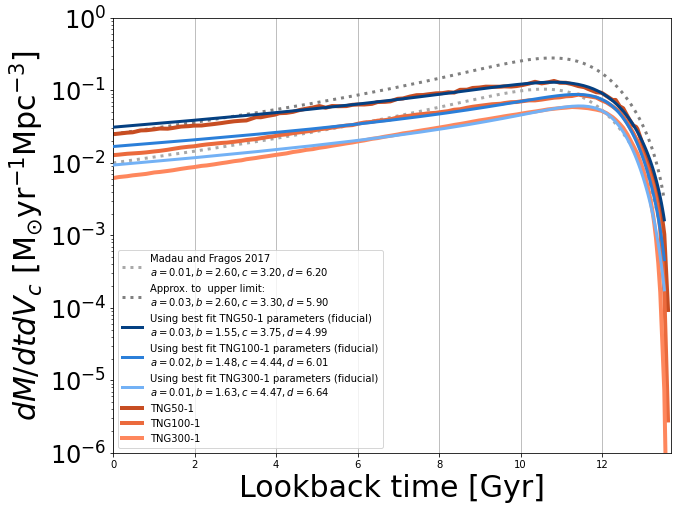

In [205]:
plot_SFR(sf_a = sf_a_best, sf_b = sf_b_best, sf_c = sf_c_best,  sf_d = sf_d_best,show_legend = True,
             redshift_list  = np.linspace(0,15, num=100), x_redshift = False, tmin=0.0, tmax = 13.7, show_fits=True)

max value 0.12965691752570246 solMass / (Mpc3 yr)  at x_max =  2.121212121212121
max value 0.08798752047562437 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275
max value 0.06100654620675864 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275


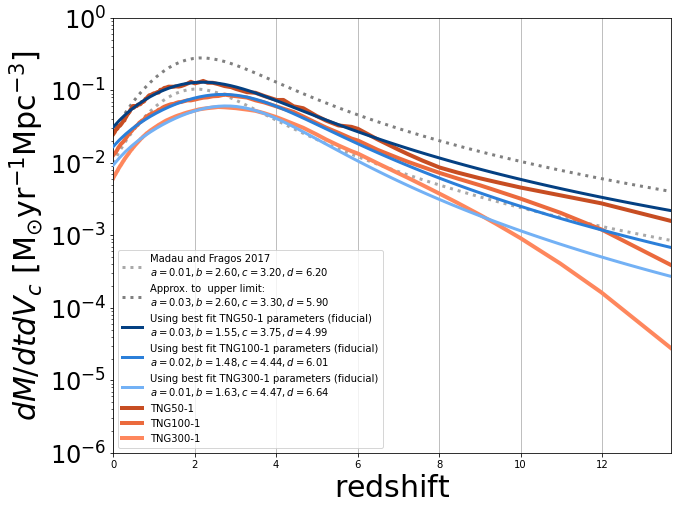

In [206]:
plot_SFR(sf_a = sf_a_best, sf_b = sf_b_best, sf_c = sf_c_best,  sf_d = sf_d_best,show_legend = True,
             redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 13.7, show_fits=True)

## Merger rates

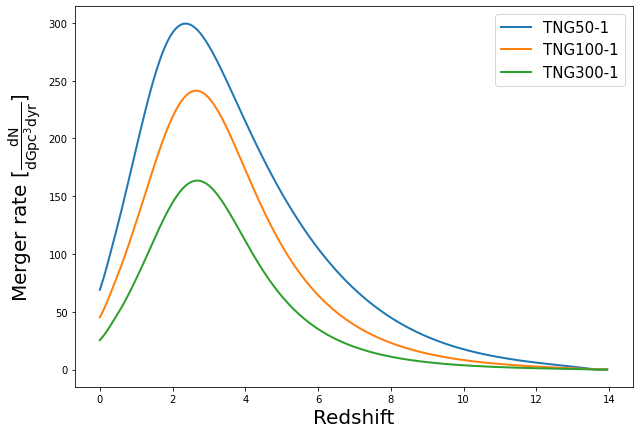

In [167]:
fig, axes = plt.subplots(1, 1, figsize=(10, 7))

fid_rates = ['1_Rate_info_TNG50.h5', '1_Rate_info_TNG100.h5', '1_Rate_info_TNG300.h5']
for i, rfile in enumerate(fid_rates):
    rate_key = 'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(fit_param_vals[i][0], 3), 
                                                                                      np.round(fit_param_vals[i][1], 3), 
                                                                                      np.round(fit_param_vals[i][4], 3), 
                                                                                      np.round(fit_param_vals[i][2], 3), 
                                                                                      np.round(fit_param_vals[i][3], 3), 
                                                                                      np.round(fit_param_vals[i][5], 3), 
                                                                                      np.round(fit_param_vals[i][6], 3), 
                                                                                      np.round(fit_param_vals[i][7], 3), 
                                                                                      np.round(fit_param_vals[i][8], 3))
    
    with h5.File(data_dir + rfile ,'r') as File:
        redshifts      = File[rate_key]['redshifts'][()]
        merger_rate    = File[rate_key]['merger_rate'][()]
    
    total_merger_rate = np.sum(merger_rate, axis=0)
    plt.plot(redshifts, total_merger_rate, label='TNG%s'%labels[i], lw=2)
    
plt.xlabel('Redshift', fontsize=20)
plt.ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=20)
#plt.yscale('log')
plt.legend(fontsize=15)
plt.savefig('merger_rates_TNG.png')

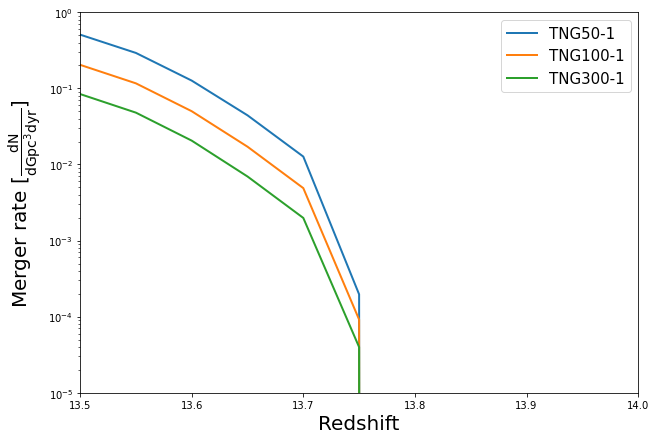

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(10, 7))

fid_rates = ['1_Rate_info_TNG50.h5', '1_Rate_info_TNG100.h5', '1_Rate_info_TNG300.h5']
for i, rfile in enumerate(fid_rates):
    rate_key = 'Rates_mu0%s_muz%s_alpha%s_sigma0%s_sigmaz%s_a%s_b%s_c%s_d%s_zBinned'%(np.round(fit_param_vals[i][0], 3), 
                                                                                      np.round(fit_param_vals[i][1], 3), 
                                                                                      np.round(fit_param_vals[i][4], 3), 
                                                                                      np.round(fit_param_vals[i][2], 3), 
                                                                                      np.round(fit_param_vals[i][3], 3), 
                                                                                      np.round(fit_param_vals[i][5], 3), 
                                                                                      np.round(fit_param_vals[i][6], 3), 
                                                                                      np.round(fit_param_vals[i][7], 3), 
                                                                                      np.round(fit_param_vals[i][8], 3))
    
    with h5.File(data_dir + rfile ,'r') as File:
        redshifts      = File[rate_key]['redshifts'][()]
        merger_rate    = File[rate_key]['merger_rate'][()]
    
    total_merger_rate = np.sum(merger_rate, axis=0)
    plt.plot(redshifts, total_merger_rate, label='TNG%s'%labels[i], lw=2)
    
plt.xlabel('Redshift', fontsize=20)
plt.ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=20)
plt.legend(fontsize=15)
plt.xlim(13.5, 14)
plt.ylim(10**-5, 1)
plt.yscale('log')
plt.savefig('merger_rates_TNG_zoomed.png')